In [1]:
# Install torch geometric -- for pyg
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
import pickle
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Building the SkyNet Dataset

We load our preprocessed flight-delay graphs using a custom `SkyNetDataset` class.
Each graph represents a **6-hour block** of the US flight network, where:

- **Nodes** = Airports (with geographic & weather features)
- **Edges** = Individual flights (with scheduling & operational features)
- **Labels** = Departure delays for each flight (regression target)

We support two evaluation modes:

- **Month Split**  
  - Train on **Jan–Sep**  
  - Test on **Oct–Dec**
- **Random 80/20 Split**  
  - Merge all individual graphs
  - Mask 20% of the edges for test time.
  - Train on the other 80% random edges.

This ensures we evaluate **temporal generalization** rather than random splits.

In [14]:
class SkyNetDataset(InMemoryDataset):
    def __init__(self, root, mode='month_split', transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.mode = mode

        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        data_list = [self.get(i) for i in range(len(self))]

        new_list = []
        for data in data_list:

            # extract month/day from Python datetime
            t = data.time
            month = t.month
            day = t.day

            num_edges = data.edge_index.size(1)

            # MONTH-SPLIT (whole graph train/test)
            if self.mode == 'month_split':
                if 1 <= month <= 9:
                    train_mask = torch.ones(num_edges, dtype=torch.bool)
                    test_mask  = torch.zeros(num_edges, dtype=torch.bool)
                else:
                    train_mask = torch.zeros(num_edges, dtype=torch.bool)
                    test_mask  = torch.ones(num_edges, dtype=torch.bool)

            # WEEK-SPLIT (edge-level)
            elif self.mode == 'week_split':
                # weeks 1–3 = days 1–21 → train
                # week 4    = days ≥22   → test
                train_mask = torch.tensor([day <= 21]*num_edges, dtype=torch.bool)
                test_mask  = ~train_mask

            else:
                raise ValueError("mode must be 'month_split' or 'week_split'")

            data.train_edge_mask = train_mask
            data.test_edge_mask  = test_mask
            new_list.append(data)

        self.data, self.slices = self.collate(new_list)

    @property
    def raw_file_names(self): return []
    @property
    def processed_file_names(self): return ['flight_graphs.pt']
    def process(self): pass

## Merging Multiple Temporal Graphs

Each 6-hour time block is stored as a separate graph.  
To train a standard GCN effectively, we merge all training graphs into a single
large graph and do the same for testing.

Key details:

- Node indices are shifted so graphs do not overlap.
- We do **not** coalesce edges.  
  Flights between the same airports in different months are distinct edges.
- We concatenate:
  - node features `x`
  - edge indices `edge_index`
  - edge features `edge_attr`
  - labels `y`

This produces one large graph for training and one for testing, which allows
efficient message passing while maintaining strict temporal separation.

In [ ]:
dataset = SkyNetDataset(
    root='/content/drive/Shareddrives/CS_224W_Project/data/data/skynet_clean_graphs',
    mode='month_split'
)

# Split graphs by month: Jan–Sep -> train, Oct–Dec -> test.
# Each graph corresponds to a 6-hour window, so this enforces
# a *temporal* train/test split rather than randomizing.
train_graphs = [g for g in dataset if g.time.month <= 9]   # Jan–Sep
test_graphs  = [g for g in dataset if g.time.month >= 10]  # Oct–Dec

def merge_graphs(graph_list):
    """
    Merge multiple PyG Data objects into a single large graph.

    We do this so the GCN trains on one big connected component rather
    than many tiny ones. Edge indices must be shifted so that nodes
    from consecutive graphs don't overlap.
    """
    x_list = []
    ei_list = []
    ea_list = []
    y_list = []

    cumulative_nodes = 0

    for g in graph_list:
        N = g.num_nodes

        # append node features
        x_list.append(g.x)

        # shift edge indices by cumulative node count
        ei_list.append(g.edge_index + cumulative_nodes)

        # append edges + labels
        ea_list.append(g.edge_attr)
        y_list.append(g.y)

        cumulative_nodes += N

    # concatenate all
    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(ei_list, dim=1)
    edge_attr  = torch.cat(ea_list, dim=0)
    y          = torch.cat(y_list, dim=0)

    # masks (all train for train graph, all test for test graph)
    num_edges = edge_index.size(1)

    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        train_edge_mask=torch.ones(num_edges, dtype=torch.bool),
        test_edge_mask=torch.zeros(num_edges, dtype=torch.bool)
    )
    data.num_nodes = x.size(0)
    return data

#  Build final merged graphs
train_graph = merge_graphs(train_graphs)
test_graph  = merge_graphs(test_graphs)

# For test_graph: invert masks
test_graph.train_edge_mask[:] = False
test_graph.test_edge_mask[:] = True

print(train_graph)
print(test_graph)

train_loader = DataLoader([train_graph], batch_size=1)
test_loader  = DataLoader([test_graph],  batch_size=1)

Data(x=[116844, 9], edge_index=[2, 252484], edge_attr=[252484, 8], y=[252484], train_edge_mask=[252484], test_edge_mask=[252484], num_nodes=116844)
Data(x=[39376, 9], edge_index=[2, 84292], edge_attr=[84292, 8], y=[84292], train_edge_mask=[84292], test_edge_mask=[84292], num_nodes=39376)


## GCN Model for Edge-Level Delay Prediction

We use a 3-layer Graph Convolutional Network to compute node embeddings.
To produce predictions on edges (flights), we concatenate:

- Source airport embedding
- Destination airport embedding
- Raw edge features (flight metadata)

These are passed through an MLP to predict the delay for each flight.

The model includes:
- **BatchNorm** for training stability  
- **Dropout** for regularization  
- **Edge MLP** for final regression  

In [ ]:
# ===========================================================
# GCN model with BN + Dropout + Edge MLP (kept simple)
# ===========================================================
class EdgeRegressionGCN3(nn.Module):
    def __init__(self, node_in, edge_in, hid=128, dropout=0.3):
        super().__init__()
        self.dropout = dropout

        self.conv1 = GCNConv(node_in, hid)
        self.conv2 = GCNConv(hid, hid)
        self.conv3 = GCNConv(hid, hid)

        self.bn1 = nn.BatchNorm1d(hid)
        self.bn2 = nn.BatchNorm1d(hid)
        self.bn3 = nn.BatchNorm1d(hid)

        self.edge_mlp = nn.Sequential(
            nn.Linear(hid*2 + edge_in, hid),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid, hid//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid//2, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        z = F.relu(self.bn1(self.conv1(x, edge_index)))
        z = F.dropout(z, p=self.dropout, training=self.training)

        z = F.relu(self.bn2(self.conv2(z, edge_index)))
        z = F.dropout(z, p=self.dropout, training=self.training)

        z = F.relu(self.bn3(self.conv3(z, edge_index)))
        z = F.dropout(z, p=self.dropout, training=self.training)

        src, dst = edge_index
        e = torch.cat([z[src], z[dst], edge_attr], dim=1)
        return self.edge_mlp(e).squeeze(-1)

## Label Normalization

Flight delays have a long-tailed distribution with large variance.  
To stabilize training, we normalize all labels using the mean and standard
deviation of the **training set only**.

$$
y_{\text{norm}} = \frac{y - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

Predictions on the test set are **denormalized** before computing final metrics.

In [ ]:
# Normalize labels using RAW y BEFORE merging
all_train_y = torch.cat([g.y for g in train_graphs])  # raw, unmerged y
y_mean = all_train_y.mean()
y_std = all_train_y.std()

train_graph.y = (train_graph.y - y_mean) / y_std
test_graph.y  = (test_graph.y - y_mean) / y_std

# Data loaders
train_loader = DataLoader([train_graph], batch_size=1)
test_loader  = DataLoader([test_graph], batch_size=1)

# Model + optimizer
model = EdgeRegressionGCN3(
    node_in=train_graph.x.size(1),
    edge_in=train_graph.edge_attr.size(1),
    hid=256,
    dropout=0.3
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

## Training Setup

We train the model using mean squared error (MSE) over the edges marked as
training edges. Since we merged all training graphs into a single graph,
we can treat each mini-batch as the full graph (batch size = 1).

Key settings:
- Optimizer: **Adam (lr = 1e-3)**
- Loss: **MSELoss**
- Epochs: **70**
- Single large-graph mini-batching for efficiency

In [ ]:
# Simple training loop with loss tracking for plotting
def train(model, loader, optimizer, criterion, epochs=40):
    model.train()
    loss_history = []   # <--- store losses here

    for epoch in range(epochs):
        total_loss = 0

        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            loss = criterion(pred[batch.train_edge_mask], batch.y[batch.train_edge_mask])

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        loss_history.append(total_loss)   # <--- record loss

        print(f"Epoch {epoch+1:03d} | Loss = {total_loss:.4f}")

    return model, loss_history

## Evaluation Metrics

We evaluate the model on the merged test graph, using only edges marked as
test edges.

Metrics computed:
- **MSE** (Mean Squared Error)
- **RMSE** (Root MSE)
- **MAE** (Mean Absolute Error)

All metrics are reported in **raw delay minutes** after denormalization.
This lets us compare the GCN directly to classical regression baselines.

In [ ]:
# Evaluation (denormalize outputs)
@torch.no_grad()
def evaluate(model, loader):
    model.eval()

    total_mse = 0
    total_mae = 0
    total_count = 0

    for batch in loader:
        batch = batch.to(device)

        pred_norm = model(batch.x, batch.edge_index, batch.edge_attr)

        # unnormalize
        pred = pred_norm * y_std + y_mean
        target = batch.y * y_std + y_mean

        mask = batch.test_edge_mask
        p = pred[mask]
        t = target[mask]

        total_mse += F.mse_loss(p, t, reduction='sum').item()
        total_mae += F.l1_loss(p, t, reduction='sum').item()
        total_count += t.numel()

    return {
        "mse": total_mse / total_count,
        "rmse": (total_mse / total_count) ** 0.5,
        "mae": total_mae / total_count
    }

In [ ]:
# Train and evaluate
trained_model, loss_history = train(model, train_loader, optimizer, criterion, epochs=70)
results = evaluate(trained_model, test_loader)

print("\n=== FINAL TEST RESULTS ===")
print("RMSE:", results["rmse"])
print("MAE :", results["mae"])


Epoch 001 | Loss = 52.8789
Epoch 002 | Loss = 58.0452
Epoch 003 | Loss = 41.6119
Epoch 004 | Loss = 17.6662
Epoch 005 | Loss = 17.7958
Epoch 006 | Loss = 23.8754
Epoch 007 | Loss = 21.8595
Epoch 008 | Loss = 14.9870
Epoch 009 | Loss = 9.4105
Epoch 010 | Loss = 7.6702
Epoch 011 | Loss = 8.2292
Epoch 012 | Loss = 9.0358
Epoch 013 | Loss = 8.9410
Epoch 014 | Loss = 7.7493
Epoch 015 | Loss = 6.0141
Epoch 016 | Loss = 4.4345
Epoch 017 | Loss = 3.3201
Epoch 018 | Loss = 2.7377
Epoch 019 | Loss = 2.5856
Epoch 020 | Loss = 2.6335
Epoch 021 | Loss = 2.6719
Epoch 022 | Loss = 2.6267
Epoch 023 | Loss = 2.4345
Epoch 024 | Loss = 2.1083
Epoch 025 | Loss = 1.7308
Epoch 026 | Loss = 1.4204
Epoch 027 | Loss = 1.1678
Epoch 028 | Loss = 0.9932
Epoch 029 | Loss = 0.9079
Epoch 030 | Loss = 0.8720
Epoch 031 | Loss = 0.8667
Epoch 032 | Loss = 0.8612
Epoch 033 | Loss = 0.8517
Epoch 034 | Loss = 0.8047
Epoch 035 | Loss = 0.7612
Epoch 036 | Loss = 0.6965
Epoch 037 | Loss = 0.6263
Epoch 038 | Loss = 0.5678
Epoc

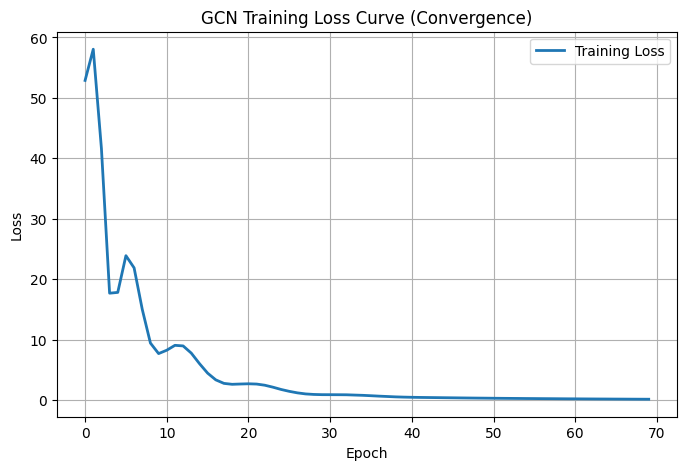

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCN Training Loss Curve (Convergence)")
plt.grid(True)
plt.legend()
plt.show()

### SkyNetDataset: Random 80/20 Edge Split per Graph

In this experiment, we do **not** split by time (months or weeks).  
Instead, every graph (each 6-hour snapshot of the flight network) gets a **random 80/20 split of edges**:

- **80% of edges** -> training  
- **20% of edges** -> testing  

This creates a purely structure-based learning setup, where the GNN must learn patterns in:
- airport features,
- weather,
- flight attributes,
- and connectivity structure,

without relying on chronological information.

This split tests whether the model can learn general flight-delay relationships independent of time.

For each graph:
1. Count the edges  
2. Generate a random permutation  
3. Assign 80% to training, 20% to testing  
4. Store boolean masks inside the Data object  

In [ ]:
class SkyNetDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)

        # Load processed graphs from disk
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

        # Convert slices to list of Data objects
        data_list = [self.get(i) for i in range(len(self))]

        new_list = []
        for data in data_list:
            num_edges = data.edge_index.size(1)

            # ---- RANDOM 80/20 SPLIT ----
            perm = torch.randperm(num_edges)
            split = int(0.8 * num_edges)

            train_idx = perm[:split]
            test_idx  = perm[split:]

            train_mask = torch.zeros(num_edges, dtype=torch.bool)
            test_mask  = torch.zeros(num_edges, dtype=torch.bool)
            train_mask[train_idx] = True
            test_mask[test_idx] = True

            data.train_edge_mask = train_mask
            data.test_edge_mask  = test_mask

            new_list.append(data)

        # Rebuild unified data + slices
        self.data, self.slices = self.collate(new_list)

    @property
    def raw_file_names(self): return []

    @property
    def processed_file_names(self): return ['flight_graphs.pt']

    def process(self): pass

### Merging All 12 Months into a Single Large Graph

To allow the GNN to use information across the entire year, we merge all individual
6-hour flight graphs into one unified graph:

- All node features are concatenated  
- All edges are concatenated  
- Edge indices are shifted so node IDs remain unique  
- Train/test masks from each graph are also concatenated  

This produces **one huge graph** containing:
- all airports for all months,
- all flights for the entire year,
- and a consistent global train/test split.

This approach is similar to a transductive learning setup used in citation-network GNNs.

In [ ]:
dataset = SkyNetDataset(
    root='/content/drive/Shareddrives/CS_224W_Project/data/data/skynet_clean_graphs'
)

# Merging ALL graphs (12 months)
all_graphs = [g for g in dataset]

def merge_graphs(graph_list):
    """
    Merge multiple PyG Data objects into a single large graph.

    We do this so the GCN trains on one big connected component rather
    than many tiny ones. Edge indices must be shifted so that nodes
    from consecutive graphs don't overlap.
    """
    x_list, ei_list, ea_list, y_list = [], [], [], []
    mask_train_list, mask_test_list = [], []

    cumulative_nodes = 0

    for g in graph_list:
        N = g.num_nodes

        x_list.append(g.x)
        ei_list.append(g.edge_index + cumulative_nodes)
        ea_list.append(g.edge_attr)
        y_list.append(g.y)

        mask_train_list.append(g.train_edge_mask)
        mask_test_list.append(g.test_edge_mask)

        cumulative_nodes += N

    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(ei_list, dim=1)
    edge_attr  = torch.cat(ea_list, dim=0)
    y          = torch.cat(y_list, dim=0)

    train_mask = torch.cat(mask_train_list, dim=0)
    test_mask  = torch.cat(mask_test_list, dim=0)

    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        train_edge_mask=train_mask,
        test_edge_mask=test_mask
    )
    data.num_nodes = x.size(0)

    return data

big_graph = merge_graphs(all_graphs)
print(big_graph)

### Normalizing Delay Labels

The target variable `y` (departure delay in minutes) has a high natural variance
(standard deviation ≈ 40 minutes).  
To stabilize training, we normalize the labels **using only the training edges**:

$$
y_{\text{norm}} = \frac{y - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

This keeps test data completely unseen during normalization.

During evaluation, we convert predictions back to real minutes.

In [ ]:
all_train_y = big_graph.y[big_graph.train_edge_mask]
y_mean = all_train_y.mean()
y_std  = all_train_y.std()

big_graph.y = (big_graph.y - y_mean) / y_std

loader = DataLoader([big_graph], batch_size=1)

### Training on the Unified Graph

We train the model on a single giant graph with full batching (batch size = 1).

This means:
- The GNN performs message passing over the entire US flight network (all months)
- Training edges drive the gradient updates
- Test edges remain masked and are only used during evaluation

The loss curve reflects **normalized MSE**, not real delay minutes.  
Real RMSE and MAE are computed after denormalization.

In [ ]:
trained_model, loss_history = train(model, loader, optimizer, criterion, epochs=70)
results = evaluate(trained_model, loader)

In [ ]:
print("RMSE:", results["rmse"])
print("MAE:", results["mae"])

RMSE: 26.22583012976106
MAE: 19.738432638101827


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCN Training Loss Curve (without weather data)")
plt.grid(True)
plt.legend()
plt.show()